<a href="https://colab.research.google.com/github/jchavescoelho/MCV-M5-Team7/blob/main/TASK_B_C_FasterRcnn_RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

### Load RetinaNet/Faster_rcnn model

In [4]:
cfg = get_cfg()

#Select model

# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)


## Prepare the dataset

We use MIT Split Dataset which has eigth classes: opencountry, coast, forest, highway, inside_city, mountain, street, tallbuilding.



In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
# download, decompress the data
!unzip "/content/drive/My Drive/MIT_split.zip" > /dev/null

replace MIT_split/test/coast/art1130.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


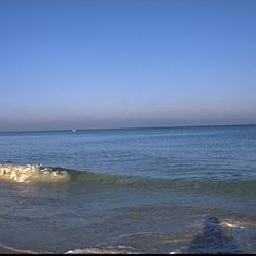

In [7]:
im = cv2.imread("/content/MIT_split/test/coast/art1130.jpg")
cv2_imshow(im)

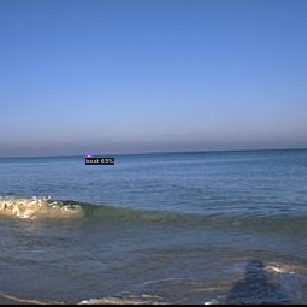

In [8]:
# We can use `Visualizer` to draw the predictions on the image.
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

Register the MIT_split dataset to detectron2.
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. 
We do not take into account annotations, because our dataset does not have a GT of object detection


In [9]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_mitsplit_dicts(img_dir):
    # json_file = os.path.join(img_dir, "via_region_data.json")
    # with open(json_file) as f:
    #     imgs_anns = json.load(f)

    dataset_dicts = []
    idx = 0
    for filename in os.listdir(img_dir):
      record = {}
      if os.path.isfile(os.path.join(img_dir, filename)) and filename.endswith('.jpg'):
        height, width = cv2.imread(os.path.join(img_dir, filename)).shape[:2]

        record["file_name"] = os.path.join(img_dir, filename)
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        #record["annotations"] = None
        dataset_dicts.append(record)
        idx+=1
    return dataset_dicts


for d in ["Opencountry", "coast", "forest", "highway", "inside_city", "mountain", "street", "tallbuilding"]:
  DatasetCatalog.register("mit_split_"+d, lambda d=d: get_mitsplit_dicts("/content/MIT_split/test/"+d))
  MetadataCatalog.get("mit_split_"+d)
mitsplit_metadata = MetadataCatalog.get("mitsplit_test")


To verify the data loading is correct, let's visualize randomly selected samples:



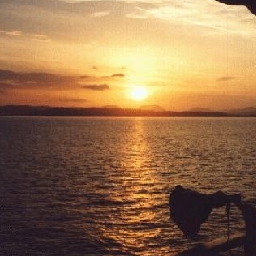

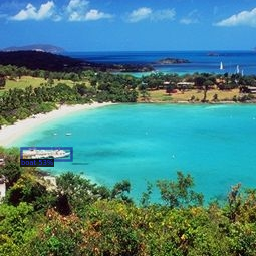

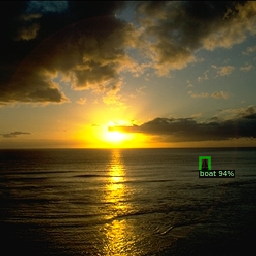

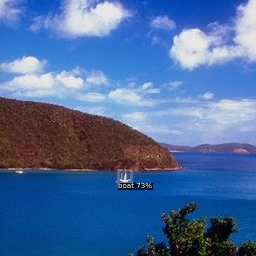

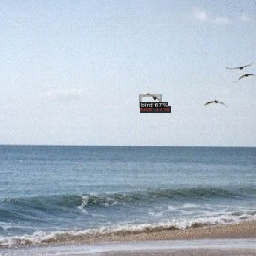

In [21]:
img_dir = "/content/MIT_split/test/coast"
dataset = os.listdir(img_dir)

for file_name in random.sample(dataset, 5):

  im = cv2.imread(os.path.join(img_dir, file_name))
  outputs = predictor(im)
  # instances = outputs["instances"][outputs["instances"].scores > 0.5]
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  


In [12]:
import time 

classes_len = len(MetadataCatalog["coco_2017_train"].thing_classes)
dic_classes = {
    "Opencountry" : np.zeros(classes_len),
    "coast" : np.zeros(classes_len),
    "forest" : np.zeros(classes_len),
    "highway" : np.zeros(classes_len),
    "inside_city" : np.zeros(classes_len),
    "mountain" : np.zeros(classes_len),
    "street" : np.zeros(classes_len),
    "tallbuilding" : np.zeros(classes_len)
}

start = time.time()

for class_name in ["Opencountry", "coast", "forest", "highway", "inside_city", "mountain", "street", "tallbuilding"]:

  img_dir = "/content/MIT_split/test/" + class_name
  dataset = os.listdir(img_dir)

  for file_name in random.sample(dataset, 75):

    im = cv2.imread(os.path.join(img_dir, file_name))
    outputs = predictor(im)
    instances = outputs["instances"][outputs["instances"].scores > 0.5]
    for i in instances.pred_classes:
      dic_classes[class_name][i] += 1

# print(dic_classes["coast"]) just to check if it is working correctly

end = time.time()

print(end - start)

56.571120500564575


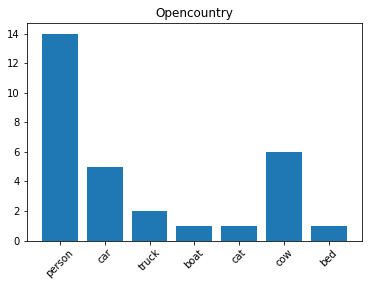

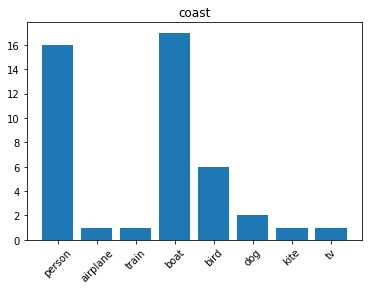

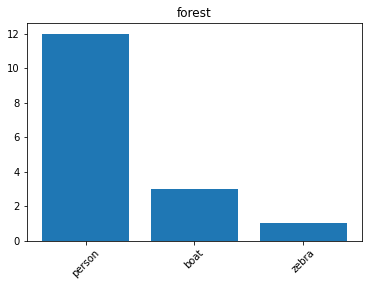

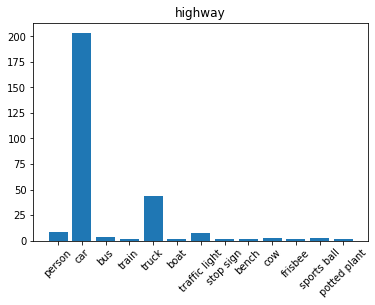

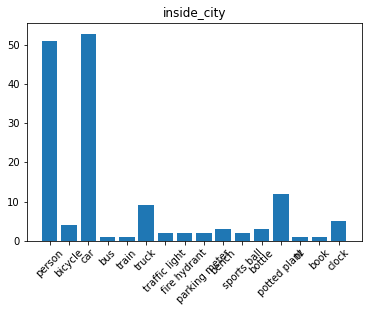

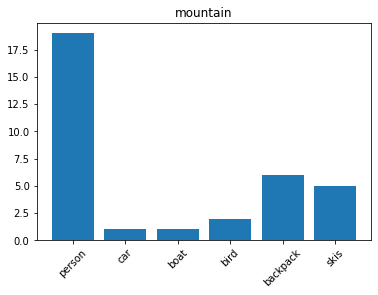

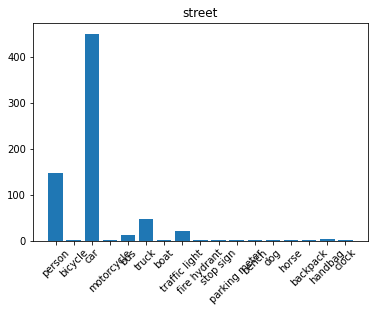

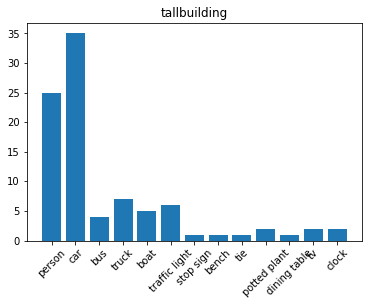

In [12]:
import matplotlib.pyplot as plt

for class_name in ["Opencountry", "coast", "forest", "highway", "inside_city", "mountain", "street", "tallbuilding"]:
  plt.figure()
  inx_list = np.where(dic_classes[class_name] > 0)[0]
  if len(inx_list) > 0:
    legends = [MetadataCatalog["coco_2017_train"].thing_classes[int(i)] for i in inx_list]
    y = [dic_classes[class_name][int(i)] for i in inx_list]
    plt.bar(legends, y)
    plt.xticks(rotation=45)
    plt.title(class_name)

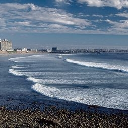

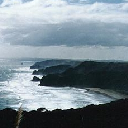

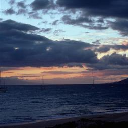

In [13]:

dataset_dicts = get_mitsplit_dicts("/content/MIT_split/test/coast")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=mitsplit_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

Then, we randomly select several samples to visualize the prediction results.

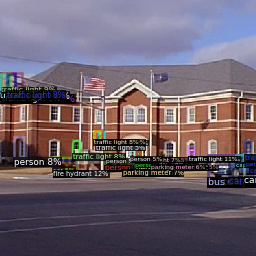

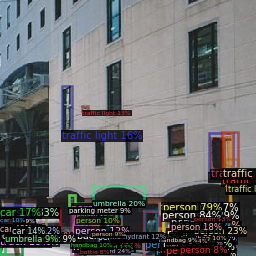

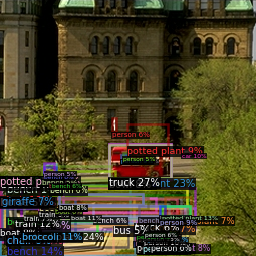

In [53]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_mitsplit_dicts("/content/MIT_split/test/inside_city")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])